In [1]:
# This is obsolete, as it doesn't work. We use a rule-based approach instead.
import pandas as pd
from transformers import AutoTokenizer, EncoderDecoderModel, BertGenerationEncoder, BertGenerationDecoder
from datasets import load_dataset
from torch import nn
from tqdm import tqdm
import numpy as np
import torch
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TRANSFORMER_MODEL_NAME = 'bert-base-uncased'
save_model_name = TRANSFORMER_MODEL_NAME.split('/')[-1]
epochs = 5
batch_size = 1
learning_rate = 2e-5
patience = 1
use_history = False

In [3]:
# Random tests to show how the tokenizer/tokenized function work
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)
inputs = tokenizer("We love doing NLI!", padding = 'max_length', add_special_tokens = False, return_tensors="pt")
print(tokenizer.decode(inputs.input_ids[0]))
print(inputs.token_to_word(0))
span = inputs.token_to_chars(1)
span[1]
# print(inputs.char_to_token(6))
# inputs

we love doing nli! [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

7

In [4]:
def process_intent_list(intent_list):
    intents = set()
    if len(intent_list) == 0:
        intents.add('other')
    for intent in intent_list:
        if intent.startswith('Restaurant'):
            intents.add(intent)
        elif intent.startswith('Hotel'):
            intents.add(intent)
        elif intent.startswith('general'):
            intents.add(intent)
        else:
            intents.add('other')
    # print(f'Original {intent_list}')
    # print(f'Modified {list(intents)}')
    return list(intents)

def process_service_list(service_list):
    services = set()
    if len(service_list) == 0:
        services.add('other')
    for service in service_list:
        if service == 'restaurant':
            services.add('restaurant')
        elif service == 'hotel':
            services.add('hotel')
        else:
            services.add('other')
        if len(services) == 3:
            break
    return list(services)

In [5]:
def preprocess_split(dataset, split):
    df = dataset[split].to_pandas()
    new_df = pd.DataFrame(columns = df.columns)
    for i in range(len(df)):
        # Taken from notebook, to know which lines to skip
        row = df.loc[i]
        if not any(set(row.turns['frames'][turn_id]['service']).intersection(['hotel', 'restaurant']) for turn_id,utt in enumerate(row.turns['utterance'])):
            continue
        
        new_df.loc[len(new_df)] = row
        # new_df.loc[len(new_df) - 1]['services'] = process_service_list(new_df.loc[len(new_df) - 1]['services'])
        # for i, frame_service in [frame['service'] for frame in df.loc[i].turns['frames']]:
            # df.loc[i].turns['frames']
    return new_df

def extract_token_bio_tags(dataset):
    unmapped_tokens_list = [] # List of 'utterance | unmapped_slot_value'
    mapped_tokens_list = []
    mapped_string_list = []
    
    for i in tqdm(range(len(dataset))):
        turns = dataset.loc[i].turns
        for j, (utterance, speaker, dialogue_act, frames) in enumerate(zip(turns['utterance'], turns['speaker'], turns['dialogue_acts'], turns['frames'])):

            if speaker != 0:
                continue
            # Skip using dialogue act intents
            # if 'other' in process_intent_list(dialogue_act['dialog_act']['act_type']):
            #     continue
            # Skip using frame services
            if 'other' in process_service_list(frames['service']):
                continue
            
            if j == 0:
                prev_user_utterance = ''
                prev_user_acts = []
                prev_bot_utterance = ''
                prev_bot_acts = []
            else:
                prev_user_utterance = turns['utterance'][j - 2]
                prev_user_acts = turns['dialogue_acts'][j - 2]['dialog_act']['act_type']
                prev_bot_utterance = turns['utterance'][j - 1]
                prev_bot_acts = turns['dialogue_acts'][j - 1]['dialog_act']['act_type']
            
            composed_prefix = ''
            if use_history:
                composed_prefix = ' | '.join([prev_user_utterance, ', '.join(prev_user_acts), prev_bot_utterance, ', '.join(prev_bot_acts)]) + ' | '
                utterance = composed_prefix + utterance
            
            span_info = dialogue_act['span_info']
            act_slot_names = span_info['act_slot_name']
            act_slot_values = span_info['act_slot_value']
            span_starts = span_info['span_start']
            span_ends = span_info['span_end']
            slots = {slot_name : {'start': start + len(composed_prefix), 'end': end + len(composed_prefix), 'value': value} for slot_name, start, end, value in zip(act_slot_names, span_starts, span_ends, act_slot_values)}


            for slot_name in slots:
                slot_start, slot_end, slot_value = slots[slot_name]['start'], slots[slot_name]['end'], slots[slot_name]['value']
                input_string = ' | '.join([utterance, utterance[slot_start:slot_end]])
                output_string = slot_value
                
                # print(input_string)
                # print(output_string)
                # print()
                
                unmapped_tokens_list.append(tokenizer(input_string, return_tensors = 'pt'))
                mapped_tokens_list.append(tokenizer(output_string, return_tensors = 'pt'))
                mapped_string_list.append(output_string)
            
    return unmapped_tokens_list, mapped_tokens_list, mapped_string_list

In [6]:
dataset = load_dataset('multi_woz_v22')

train = preprocess_split(dataset, 'train')
val = preprocess_split(dataset, 'validation')
test = preprocess_split(dataset, 'test')

train_unmapped, train_mapped, _ = extract_token_bio_tags(train)
val_unmapped, val_mapped, _ = extract_token_bio_tags(val)
test_unmapped, test_mapped, test_mapped_string = extract_token_bio_tags(test)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset multi_woz_v22 downloaded and prepared to /root/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/7452f16a8b502e97df5c04cc4ee5436464762fa93b1ce778dd14181e79d8b51a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 745/745 [00:01<00:00, 518.70it/s]


In [7]:
def batchify_mapped_unmapped(unmapped_list, mapped_list, batch_size):
    unmapped_batch = []
    unmapped_mask_batch = []
    mapped_batch = []
    mapped_mask_batch = []
    
    if mapped_list is None:
        mapped_list = range(len(unmapped_list))
    
    for unmapped, mapped in zip(unmapped_list, mapped_list):
        unmapped_batch.append(unmapped.input_ids)
        unmapped_mask_batch.append(unmapped.attention_mask)
        mapped_batch.append(mapped.input_ids)
        mapped_mask_batch.append(mapped.attention_mask)
        
        if len(unmapped_batch) == batch_size:
            yield torch.concat(unmapped_batch).long().cuda(), torch.concat(unmapped_mask_batch).cuda(), torch.concat(mapped_batch).cuda(), torch.concat(mapped_mask_batch).cuda()
            unmapped_batch.clear()
            unmapped_mask_batch.clear()
            mapped_batch.clear()
            mapped_mask_batch.clear()
    if len(unmapped_batch) != 0:
        yield torch.concat(unmapped_batch).long().cuda(), torch.concat(unmapped_mask_batch).cuda(), torch.concat(mapped_batch).cuda(), torch.concat(mapped_mask_batch).cuda()
    return None

In [8]:
def compute_loss(transformer, unmapped_list, mapped_list, batch_size):
    transformer.eval()
    losses = []
    with torch.no_grad():
        for unmapped_batch, unmapped_mask_batch, mapped_batch, mapped_mask_batch in batchify_mapped_unmapped(unmapped_list, mapped_list, batch_size):
            out = transformer(input_ids = unmapped_batch,
                          attention_mask = unmapped_mask_batch,
                          decoder_input_ids = mapped_batch,
                          decoder_attention_mask = mapped_mask_batch,
                          labels = mapped_batch)
            loss = out.loss
            losses.append(loss.item())
    transformer.train()
    return np.mean(losses)

def predict(transformer, unmapped_list):
    transformer.eval()
    predictions = []
    with torch.no_grad():
        for unmapped in tqdm(unmapped_list):
            out = transformer.generate(unmapped.input_ids.cuda(), decoder_start_token_id=transformer.config.decoder.bos_token_id)
            predictions.append(tokenizer.decode(out[0], skip_special_tokens = True))
    return predictions

In [9]:
encoder = BertGenerationEncoder.from_pretrained(TRANSFORMER_MODEL_NAME, bos_token_id=101, eos_token_id=102)
decoder = BertGenerationDecoder.from_pretrained(TRANSFORMER_MODEL_NAME, is_decoder = True, add_cross_attention = True, bos_token_id=101, eos_token_id=102)

transformer = EncoderDecoderModel(encoder = encoder, decoder = decoder).cuda()
transformer.train()
# TODO: maybe use the parameters that the pre-trained model was trained with??
optim = torch.optim.Adam(transformer.parameters(), lr = learning_rate)

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.


You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.
Some weights of BertGenerationDecoder were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.7.crossattention.self.key.weight', 'bert.encoder.layer.11.crossattention.self.value.weight', 'bert.encoder.layer.6.crossattention.self.query.weight', 'bert.encoder.layer.11.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.10.crossattention.self.query.weight', 'bert.encoder.layer.11.crossattention.self.value.bias', 'bert.encoder.layer.3.crossattention.self.key.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.5.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.6.crossattention.self.value.bias', 'bert.encoder.layer.4.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.5.crossattention.self.query.bias', 'bert.encode

/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:639: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Removed shared tensor {'decoder.lm_head.decoder.bias', 'decoder.lm_head.decoder.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


Epoch 1: Train loss = 0.9565840673299576, Val loss = 2.888902619996145


/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:639: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch 2: Train loss = 0.40958814333570437, Val loss = 0.4627634683741574


/opt/conda/lib/python3.10/site-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:639: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Epoch 3: Train loss = 1.7352835703032188, Val loss = 2.8861374422747983
Epoch 4: Train loss = 2.7857269287770117, Val loss = 2.8856542452157465
Epoch 5: Train loss = 2.7487773933486253, Val loss = 2.8817631567121262


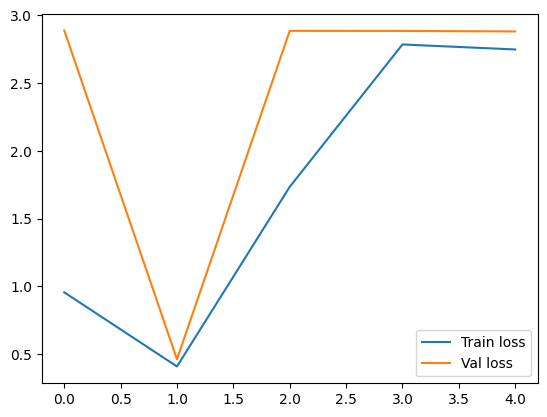

In [10]:
train_losses = []
val_losses = []
min_val_loss = np.inf

for epoch in range(epochs):
    epoch_train_loss = []
    
    for unmapped_batch, unmapped_mask_batch, mapped_batch, mapped_mask_batch in batchify_mapped_unmapped(train_unmapped, train_mapped, batch_size):
        optim.zero_grad()
        out = transformer(input_ids = unmapped_batch,
                          attention_mask = unmapped_mask_batch,
                          decoder_input_ids = mapped_batch,
                          decoder_attention_mask = mapped_mask_batch,
                          labels = mapped_batch)
        
        loss = out.loss
        loss.backward()
        optim.step()
        epoch_train_loss.append(loss.item())
    
    epoch_train_loss = np.mean(epoch_train_loss)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = compute_loss(transformer, val_unmapped, val_mapped, batch_size)
    
    print(f"Epoch {epoch + 1}: Train loss = {epoch_train_loss}, Val loss = {epoch_val_loss}")
    
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        transformer.save_pretrained('saved_models/MAP_' + save_model_name)
    
    if len(val_losses) != 0 and val_losses[-1] <= epoch_val_loss:
        waited += 1
        if waited > patience:
                val_losses.append(epoch_val_loss)
                break
    else:
        waited = 0
    
    val_losses.append(epoch_val_loss)

del transformer
del optim

plt.plot(train_losses, label = 'Train loss')
plt.plot(val_losses, label = 'Val loss')
plt.legend()
plt.show()

In [11]:
transformer = EncoderDecoderModel.from_pretrained('saved_models/MAP_' + save_model_name).cuda()

with torch.no_grad():
    predicted_mapped_string = predict(transformer, test_unmapped[:10])

predicted_mapped_string = [s.lower() for s in predicted_mapped_string]
test_mapped_string = [s.lower() for s in test_mapped_string]

for pred, test in zip(predicted_mapped_string, test_mapped_string):
    print(f"pred = {pred}, test = {test}")

acc = accuracy_score(predicted_mapped_string, test_mapped_string[:10])
print(f"Accuracy: {acc:.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

pred = centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre, test = golden wok
pred = centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre, test = 4
pred = centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre, test = hotel
pred = centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre, test = moderate
pred = centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre, test = 3
pred = centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre centre, test = 2
pred = centre centre centre centre centre centre centre centre centre centre cen